In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: IMDB Dataset.csv        


# Problem Statement

The aim of this notebook is to demonstrate how Vanilla RNN, LSTM and GRU perform on a sentiment classification task. We will use the IMDB dataset which has binary classification of sentiment reviews.

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Dataset

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


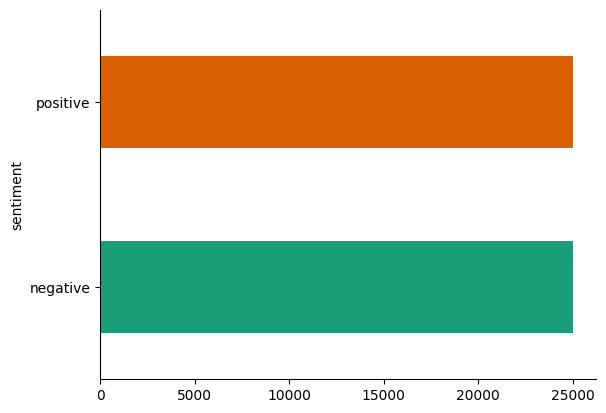

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Data pre-processing

This helps in removing unnecessary words and characters which just computational overhead to our models. By doing this we can reduce the size and resulting vector space.

## Let's remove HTML tags, Non-alphanumeric characters and convert to lower case

Except for characters like !, ? and .

In [ ]:
import re

def remove_tags(string):
    removelist = "!?."
    # Remove HTML tags
    result = re.sub(r'<.*?>', '', string)
    # Remove URLs
    result = re.sub(r'https?://\S+|www\.\S+', '', result)
    # Remove non-alphanumeric characters except word chars and chosen punctuation
    result = re.sub(r'[^\w' + re.escape(removelist) + ']', ' ', result)
    result = result.lower()
    return result

data['review'] = data['review'].apply(remove_tags)

In [ ]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive


## Stopwords removal and Lemmatization

Words like 'and', 'the', 'at', 'a' and many more provide no meaningful context for our task. hence removing these will be better for our model

Lemmatization refers to the process of changing the words to their root form. Like 'reading' to 'read'

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Stopword set
stop_words = set(stopwords.words('english'))

# Stopword removal
data['review'] = data['review'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Lemmatization
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

data['review'] = data['review'].apply(lemmatize_text)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


## Label encoding and train-test spitiing

In [ ]:
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

In [ ]:
data['sentiment'].head()

,sentiment
0,1
1,1
2,1
3,0
4,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data['review'],
    data['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=data['sentiment']
)

## Tokenization
Turns words into integer IDs based on frequency. Unknown words become \<OOV\> (Out-Of-Vocabulary token).

In [ ]:
MAX_WORDS = 10000  # Keep top 10k most frequent words
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

## Padding
Ensures all sequences have the same length (MAX_LEN) by adding zeros at the end (post padding) or cutting longer ones.

In [ ]:
MAX_LEN = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:
X_test_pad.shape

(10000, 200)

In [ ]:
X_train_pad.shape

(40000, 200)

# Model building

Lets define 3 models SimpleRNN (Vanilla RNN), LSTM and GRU. We weill aslo use an embedding layer where we convert these inputs to embeddings useful for the model.

In [ ]:
maxlen = X_train_pad.shape[1]
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from tensorflow.keras import layers

def build_model(rnn_type="SimpleRNN", embed_size=64, hidden_size=128):
    model = keras.Sequential()
    model.add(layers.Embedding(vocab_size, embed_size, input_length=maxlen))
    if rnn_type == "SimpleRNN":
        model.add(layers.SimpleRNN(hidden_size))
    elif rnn_type == "LSTM":
        model.add(layers.LSTM(hidden_size))
    elif rnn_type == "GRU":
        model.add(layers.GRU(hidden_size))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
build_model().summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available!")
else:
    print("GPU not available, using CPU.")

GPU is available!


# Training and Evaluation


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time

def train_with_timing(model, name, epochs=3):
    epoch_times = []

    class TimingCallback(keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            self.start_time = time.time()
        def on_epoch_end(self, epoch, logs=None):
            duration = time.time() - self.start_time
            epoch_times.append(duration)
            print(f"Epoch {epoch+1} time: {duration:.2f}s")

    print(f"\nTraining {name}...")
    history = model.fit(
        X_train_pad, y_train,  # Use padded sequences for training
        validation_data=(X_test_pad, y_test),  # Use padded sequences for validation
        epochs=epochs,
        batch_size=64,
        verbose=2,
        callbacks=[TimingCallback()]
    )

    # Predictions for confusion matrix
    y_pred_probs = model.predict(X_test_pad, verbose=0) # Use padded sequences for prediction
    y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred)}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    return history, epoch_times


Training SimpleRNN...
Epoch 1/10
Epoch 1 time: 14.30s
625/625 - 14s - 23ms/step - accuracy: 0.5023 - loss: 0.6992 - val_accuracy: 0.5212 - val_loss: 0.6949
Epoch 2/10
Epoch 2 time: 11.10s
625/625 - 11s - 18ms/step - accuracy: 0.5297 - loss: 0.6926 - val_accuracy: 0.5498 - val_loss: 0.6869
Epoch 3/10
Epoch 3 time: 21.51s
625/625 - 22s - 34ms/step - accuracy: 0.5594 - loss: 0.6865 - val_accuracy: 0.5775 - val_loss: 0.6794
Epoch 4/10
Epoch 4 time: 20.00s
625/625 - 20s - 32ms/step - accuracy: 0.6054 - loss: 0.6673 - val_accuracy: 0.5876 - val_loss: 0.6744
Epoch 5/10
Epoch 5 time: 20.00s
625/625 - 20s - 32ms/step - accuracy: 0.6244 - loss: 0.6538 - val_accuracy: 0.3982 - val_loss: 0.7812
Epoch 6/10
Epoch 6 time: 11.07s
625/625 - 11s - 18ms/step - accuracy: 0.6348 - loss: 0.6404 - val_accuracy: 0.3979 - val_loss: 0.8184
Epoch 7/10
Epoch 7 time: 20.65s
625/625 - 21s - 33ms/step - accuracy: 0.6382 - loss: 0.6332 - val_accuracy: 0.6178 - val_loss: 0.6684
Epoch 8/10
Epoch 8 time: 20.41s
625/625

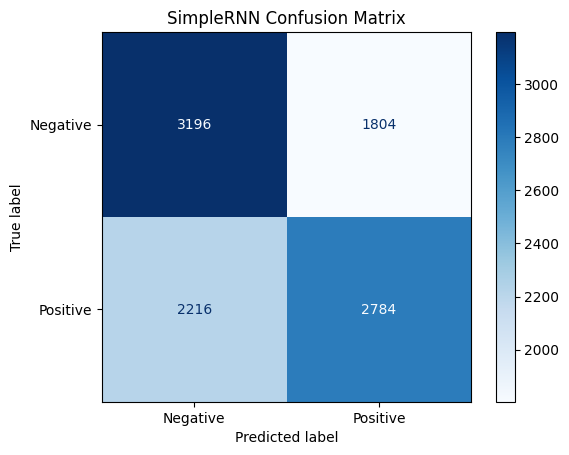


Training LSTM...
Epoch 1/10
Epoch 1 time: 10.84s
625/625 - 11s - 17ms/step - accuracy: 0.5001 - loss: 0.6958 - val_accuracy: 0.5003 - val_loss: 0.6961
Epoch 2/10
Epoch 2 time: 10.00s
625/625 - 10s - 16ms/step - accuracy: 0.5216 - loss: 0.6887 - val_accuracy: 0.5307 - val_loss: 0.6850
Epoch 3/10
Epoch 3 time: 9.31s
625/625 - 9s - 15ms/step - accuracy: 0.6104 - loss: 0.6205 - val_accuracy: 0.8222 - val_loss: 0.4090
Epoch 4/10
Epoch 4 time: 9.88s
625/625 - 10s - 16ms/step - accuracy: 0.8884 - loss: 0.2818 - val_accuracy: 0.8833 - val_loss: 0.2792
Epoch 5/10
Epoch 5 time: 10.68s
625/625 - 11s - 17ms/step - accuracy: 0.9255 - loss: 0.1996 - val_accuracy: 0.8867 - val_loss: 0.2807
Epoch 6/10
Epoch 6 time: 10.32s
625/625 - 10s - 17ms/step - accuracy: 0.9451 - loss: 0.1557 - val_accuracy: 0.8858 - val_loss: 0.2901
Epoch 7/10
Epoch 7 time: 9.76s
625/625 - 10s - 16ms/step - accuracy: 0.9628 - loss: 0.1172 - val_accuracy: 0.8818 - val_loss: 0.3293
Epoch 8/10
Epoch 8 time: 10.22s
625/625 - 10s - 

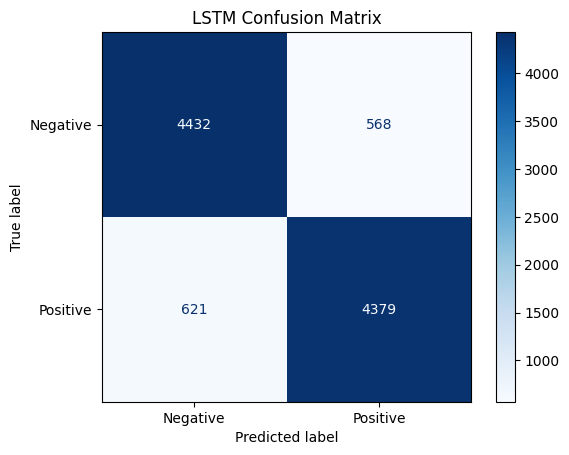


Training GRU...
Epoch 1/10
Epoch 1 time: 9.90s
625/625 - 10s - 16ms/step - accuracy: 0.5108 - loss: 0.6939 - val_accuracy: 0.5055 - val_loss: 0.6950
Epoch 2/10
Epoch 2 time: 8.61s
625/625 - 9s - 14ms/step - accuracy: 0.6193 - loss: 0.6199 - val_accuracy: 0.8125 - val_loss: 0.4637
Epoch 3/10
Epoch 3 time: 10.67s
625/625 - 11s - 17ms/step - accuracy: 0.8654 - loss: 0.3312 - val_accuracy: 0.8660 - val_loss: 0.3190
Epoch 4/10
Epoch 4 time: 8.66s
625/625 - 9s - 14ms/step - accuracy: 0.9201 - loss: 0.2157 - val_accuracy: 0.8906 - val_loss: 0.2741
Epoch 5/10
Epoch 5 time: 8.15s
625/625 - 8s - 13ms/step - accuracy: 0.9479 - loss: 0.1517 - val_accuracy: 0.8874 - val_loss: 0.3122
Epoch 6/10
Epoch 6 time: 10.31s
625/625 - 10s - 16ms/step - accuracy: 0.9703 - loss: 0.1000 - val_accuracy: 0.8801 - val_loss: 0.3693
Epoch 7/10
Epoch 7 time: 8.57s
625/625 - 9s - 14ms/step - accuracy: 0.9812 - loss: 0.0664 - val_accuracy: 0.8688 - val_loss: 0.4056
Epoch 8/10
Epoch 8 time: 10.28s
625/625 - 10s - 16ms/s

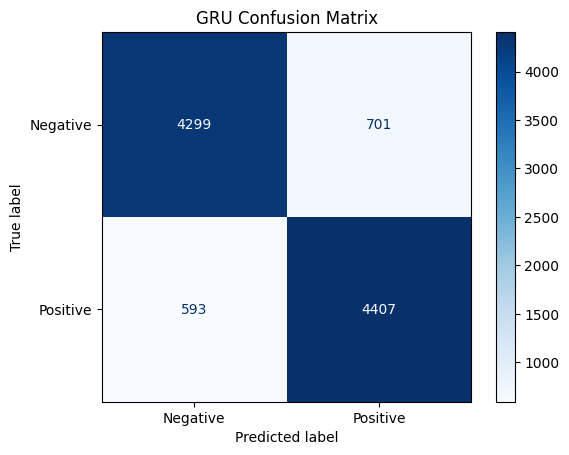

In [ ]:
results = {}
times_per_model = {}

for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
    model = build_model(rnn_type)
    history, epoch_times = train_with_timing(model, rnn_type, epochs=10)
    results[rnn_type] = history
    times_per_model[rnn_type] = epoch_times

# Result Visualization

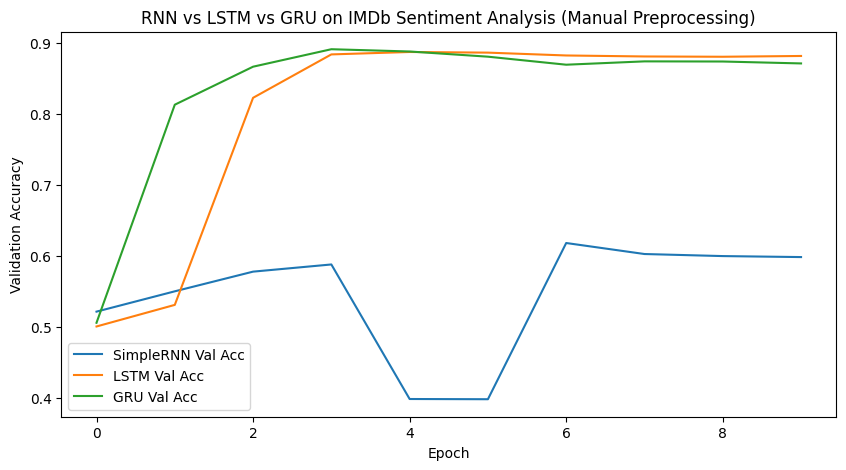

In [ ]:
plt.figure(figsize=(10, 5))
for rnn_type, history in results.items():
    plt.plot(history.history['val_accuracy'], label=f"{rnn_type} Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("RNN vs LSTM vs GRU on IMDb Sentiment Analysis (Manual Preprocessing)")
plt.show()

In [ ]:
for rnn_type, times in times_per_model.items():
    print(f"{rnn_type} average epoch time: {np.mean(times):.2f}s")

SimpleRNN average epoch time: 16.12s
LSTM average epoch time: 10.12s
GRU average epoch time: 9.34s
